# Telco Customer Churn Modeling

Here, we are trying to use the sample data from IBM base samples: the Telco Customer Churn data to do some machine learning model exploring. 

## Import Modules

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix

## Import the data file

In [4]:
df=pd.read_excel("Telco_customer_churn.xlsx")

In [5]:
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


## Data Preprocessing

### 1. Attributes Cleaning
First, getting rid of redundant attributes. Note that the columns "Churn Value", "Churn Score", "CLTV" and "Churn Reason" are collected from customers who left the company service, therefore these columns should not be used for predicting churns. For example, the "Churn Value" is identical to "Churn Label".

In [6]:
df.groupby('Churn Value')['Churn Label'].unique()

Churn Value
0     [No]
1    [Yes]
Name: Churn Label, dtype: object

So let's drop them:

In [7]:
df.drop(['Churn Label','Churn Score','CLTV','Churn Reason'],axis=1,inplace=True)
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Next, we can get some idea about how informative each column is by counting the unique values:

In [8]:
for col in df.columns:
  print(col, len(df[col].unique()))

CustomerID 7043
Count 1
Country 1
State 1
City 1129
Zip Code 1652
Lat Long 1652
Latitude 1652
Longitude 1651
Gender 2
Senior Citizen 2
Partner 2
Dependents 2
Tenure Months 73
Phone Service 2
Multiple Lines 3
Internet Service 3
Online Security 3
Online Backup 3
Device Protection 3
Tech Support 3
Streaming TV 3
Streaming Movies 3
Contract 3
Paperless Billing 2
Payment Method 4
Monthly Charges 1585
Total Charges 6531
Churn Value 2


Uninformative attributes are also called redundant attributes, and although there is no impact from information perspective, keeping those redundant attributes can slow down the training time. So let's remove them:

In [9]:
df.drop(['Count','Country','State'],axis=1,inplace=True)
df.head()

,CustomerID,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,3668-QPYBK,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,9237-HQITU,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,9305-CDSKC,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,7892-POOKP,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,0280-XJGEX,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Also note that column "CustomerID" should be removed and "Lat Long" is redundant as it is only a combination of column "Latitude" and "Longitude".

In [10]:
df.drop(['CustomerID','Lat Long'],axis=1,inplace=True)
df.head()

,City,Zip Code,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


Next, remove white spaces so that later we can draw tree structures for XGBoost model.

In [11]:
df['City'].replace(' ','_',regex=True,inplace=True)
df['City'].head()

0    Los_Angeles
1    Los_Angeles
2    Los_Angeles
3    Los_Angeles
4    Los_Angeles
Name: City, dtype: object

Also replace white spaces with underscore for column names.

In [12]:
df.columns=df.columns.str.replace(' ','_')
df.columns

Index(['City', 'Zip_Code', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen',
       'Partner', 'Dependents', 'Tenure_Months', 'Phone_Service',
       'Multiple_Lines', 'Internet_Service', 'Online_Security',
       'Online_Backup', 'Device_Protection', 'Tech_Support', 'Streaming_TV',
       'Streaming_Movies', 'Contract', 'Paperless_Billing', 'Payment_Method',
       'Monthly_Charges', 'Total_Charges', 'Churn_Value'],
      dtype='object')

### 2. Missing Data

Missing data can have large impact on modeling. A bunch of modeling algorithms cannot handle missing data, therefore, it's best to handle the missing data as a step in the preprocessing procedure.

####2.1 Identify missing data
The first step is to identify the missing values.

In [13]:
for col in df.columns:
  print(col, df[col].isnull().sum())

City 0
Zip_Code 0
Latitude 0
Longitude 0
Gender 0
Senior_Citizen 0
Partner 0
Dependents 0
Tenure_Months 0
Phone_Service 0
Multiple_Lines 0
Internet_Service 0
Online_Security 0
Online_Backup 0
Device_Protection 0
Tech_Support 0
Streaming_TV 0
Streaming_Movies 0
Contract 0
Paperless_Billing 0
Payment_Method 0
Monthly_Charges 0
Total_Charges 0
Churn_Value 0


Sometimes we can take a look at the data types to see if the data type is consistent with the meaning of the attribute.

In [14]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

While we can see that most data types are consistent, meaning that categorical attributes have "object" data type and numerical attributes have "int" or "float", the attribute "Total_Charges" which should be numerical is showing as "object". Let's try convert it to numbers.

In [15]:
for r in range(df.shape[0]):
  try:
    x = float(df['Total_Charges'][r])
  except:
    print("Index:{}, Value:'{}'".format(r, df['Total_Charges'][r]))

Index:2234, Value:' '
Index:2438, Value:' '
Index:2568, Value:' '
Index:2667, Value:' '
Index:2856, Value:' '
Index:4331, Value:' '
Index:4687, Value:' '
Index:5104, Value:' '
Index:5719, Value:' '
Index:6772, Value:' '
Index:6840, Value:' '


Now we can see that there are a few records that has blank values for "Total_Charges" and that explains why the data type is inconsistent.

####2.2 Deal with missing data

To deal with missing data, one way is to remove columns or rows that contain the missing data if there is a high proportion of missing, or we should try to impute the missing values.

For XGBoost, however, the internal way of dealing with missing data is to treat them as zeros due to "Sparcity-Aware Split Finding". Therefore, that's what we will do here.

In [16]:
df.loc[df['Total_Charges']==' ','Total_Charges']='0'

Take a look at row 2234 to double check the blank space in "Total_Charges" has indeed replaced by '0'.

In [17]:
df.iloc[2234]

City                            San_Bernardino
Zip_Code                                 92408
Latitude                               34.0849
Longitude                             -117.258
Gender                                  Female
Senior_Citizen                              No
Partner                                    Yes
Dependents                                  No
Tenure_Months                                0
Phone_Service                               No
Multiple_Lines                No phone service
Internet_Service                           DSL
Online_Security                            Yes
Online_Backup                               No
Device_Protection                          Yes
Tech_Support                               Yes
Streaming_TV                               Yes
Streaming_Movies                            No
Contract                              Two year
Paperless_Billing                          Yes
Payment_Method       Bank transfer (automatic)
Monthly_Charg

Then we can safely convert the value of "Total_Charges" to float type.

In [18]:
df['Total_Charges']=df['Total_Charges'].astype('float64')

In [19]:
df.dtypes

City                  object
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

Then we can further replace the white spaces between words with underscores in all values in the data frame since we have dealt with the missing data.

In [20]:
df.replace(' ','_',regex=True,inplace=True)
df.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


### 3. Data Formatting

#### 3.1 Split dependent Y and independent data X


In [21]:
X=df.drop('Churn_Value',axis=1).copy()
y=df['Churn_Value'].copy()

#### 3.2 Further format attribute values in X

For many machine learning algorithms, only numerical or boolean data is suitable, that means we need to further format the categorical values that has data type 'object' to make X suitable for modeling.

Here, we will one-hot-encoding the categorical values.

In [22]:
categorical_cols=[col for col in df.columns if df[col].dtypes=='object']
categorical_cols

['City',
 'Gender',
 'Senior_Citizen',
 'Partner',
 'Dependents',
 'Phone_Service',
 'Multiple_Lines',
 'Internet_Service',
 'Online_Security',
 'Online_Backup',
 'Device_Protection',
 'Tech_Support',
 'Streaming_TV',
 'Streaming_Movies',
 'Contract',
 'Paperless_Billing',
 'Payment_Method']

We can take a look at the most common values for the categorical attributes at the two groups with churn or no churn to get some idea of potential associations. 

In [23]:
df.groupby('Churn_Value')[categorical_cols].agg(lambda x: x.value_counts().index[0]) #get the most common value

,City,Gender,Senior_Citizen,Partner,Dependents,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method
Churn_Value,,,,,,,,,,,,,,,,,
0,Los_Angeles,Male,No,Yes,No,Yes,No,DSL,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Mailed_check
1,Los_Angeles,Female,No,No,No,Yes,Yes,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check


Now, we use the pd.get_dummies to do the one-hot-encoding for all categorical columns.

In [24]:
X_encoded=pd.get_dummies(X, columns=categorical_cols)
X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador_City,City_Amboy,City_Anaheim,City_Anderson,City_Angels_Camp,City_Angelus_Oaks,City_Angwin,City_Annapolis,City_Antelope,City_Antioch,City_Anza,City_Apple_Valley,City_Applegate,...,Senior_Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone_Service_No,Phone_Service_Yes,Multiple_Lines_No,Multiple_Lines_No_phone_service,Multiple_Lines_Yes,Internet_Service_DSL,Internet_Service_Fiber_optic,Internet_Service_No,Online_Security_No,Online_Security_No_internet_service,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,90005,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,90006,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
3,90010,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
4,90015,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0


In [25]:
X_encoded.shape

(7043, 1178)

### 4. Build preliminary XGBoost Model
####4.1 Divide the data into train/test subsets
First, let's check the overall balance of the churn/no churn.

In [26]:
sum(y)/len(y)

0.2653698707936959

So, as expected, there are around 1/4 of the sample has churned. Therefore, this imbalance should be treated. Here, we specify "stratify=y" when calling train_test_split().

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42, 
                                                    stratify=y)

Quick check to confirm that the stratified split works.

In [28]:
print(sum(y_train)/len(y_train), sum(y_test)/len(y_test))

0.2653144016227181 0.26549929010885


In [29]:
len(y_train)/len(y)

0.6999858015050404

#### 4.2 Build XGBoost Model

In [30]:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',seed=42)
clf_xgb.fit(X_train,y_train,verbose=True,early_stopping_rounds=10,
            eval_metric='aucpr',eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.583651
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.59387
[2]	validation_0-aucpr:0.606663
[3]	validation_0-aucpr:0.607181
[4]	validation_0-aucpr:0.6082
[5]	validation_0-aucpr:0.614727
[6]	validation_0-aucpr:0.623911
[7]	validation_0-aucpr:0.625478
[8]	validation_0-aucpr:0.625095
[9]	validation_0-aucpr:0.647748
[10]	validation_0-aucpr:0.644691
[11]	validation_0-aucpr:0.650267
[12]	validation_0-aucpr:0.649664
[13]	validation_0-aucpr:0.646857
[14]	validation_0-aucpr:0.655209
[15]	validation_0-aucpr:0.65526
[16]	validation_0-aucpr:0.656589
[17]	validation_0-aucpr:0.654829
[18]	validation_0-aucpr:0.657154
[19]	validation_0-aucpr:0.657445
[20]	validation_0-aucpr:0.659189
[21]	validation_0-aucpr:0.655936
[22]	validation_0-aucpr:0.65664
[23]	validation_0-aucpr:0.658813
[24]	validation_0-aucpr:0.660416
[25]	validation_0-aucpr:0.658686
[26]	validation_0-aucpr:0.657353
[27]	validation_0-aucpr:0.657655
[28]	validation_0-aucpr:0

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

We can see from the log that when one iteration provides poorer validation performance than the predecessor, the XGBoost will try 10 more rounds to see if it can build a better model. If not, the previous best performer will be the choice of final model. This is how early stopping is working.

Next, we can take a look at the XGB model on its performance on test data.

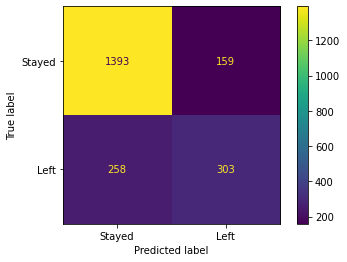

In [31]:
plot_confusion_matrix(clf_xgb,X_test,y_test,values_format='d',display_labels=["Stayed","Left"])

We can see from the confusion matrix that, while the model did a decent job predicting the "Stayed" customers, it did pretty poor predicting the "Left" customers (barely better than random guessing, i.e. 50%). Next, we will try to optimize XGBoost model.

#### 4.3 Optimize XGBoost model
Part of the reasons why the previous model did not do well in predicting "Left" customers could be due to the imbalance. The "Left" customers has a small sample size and therefore is proportionally "under-emphasized" by the model. So we will see if we can use parameter **scale_pos_weight** to alleviate this problem. And we can use GridSearch and cross validation to get the optimal value for the hyperparameters.

In [32]:
# Round 1
param_grid={
    'max_depth':[3,4,5],
    'learning_rate':[0.01,0.05,0.1],
    'gamma':[0,0.25,1], #min loss required to further split a node
    'reg_lambda':[0,1,10],
    'scale_pos_weight':[1,3,5]
}

optimal_params=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',
                                                        seed=42,
                                                        subsample=0.9, #use 90% of sample for tree building
                                                        colsample_bytree=0.5), #use half of the features for tree building
                            param_grid=param_grid,
                            scoring='roc_auc',
                            verbose=0,
                            n_jobs=10,
                            cv=3)

optimal_params.fit(X_train,y_train,verbose=False,early_stopping_rounds=10,
            eval_metric='auc',eval_set=[(X_test,y_test)])

KeyboardInterrupt: ignored

In [ ]:
print(optimal_params.best_params_)

In [37]:
# Round 2
param_grid={
    'max_depth':[4],
    'learning_rate':[0.05],
    'gamma':[0,0.1,0.25], #min loss required to further split a node
    'reg_lambda':[1,3,5],
    'scale_pos_weight':[3]
}

optimal_params2=GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',
                                                        seed=42,
                                                        subsample=0.9, #use 90% of sample for tree building
                                                        colsample_bytree=0.5), #use half of the features for tree building
                            param_grid=param_grid,
                            scoring='roc_auc',
                            verbose=0,
                            n_jobs=10,
                            cv=3)

optimal_params2.fit(X_train,y_train,verbose=False,early_stopping_rounds=10,
            eval_metric='auc',eval_set=[(X_test,y_test)])

GridSearchCV(cv=3, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=0.5, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=42, silent=None,
                                     subsample=0.9, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'gamma': [0, 0.1, 0.25], 'learning_rate': [0.05],
                         'max_depth': [4], 'reg_lambda': [1, 3, 5],
                         'scale_po

In [38]:
print(optimal_params2.best_params_)

{'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'reg_lambda': 1, 'scale_pos_weight': 3}


#### 4.4 Build XGBoost model with optimized parameters

In [33]:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',seed=42,
                          gamma=0,learning_rate=0.05,max_depth=4,
                          reg_lambda=1,subsample=0.9,colsample_bytree=0.5,
                          scale_pos_weight=3)
clf_xgb.fit(X_train,y_train,verbose=True,early_stopping_rounds=10,
            eval_metric='auc',eval_set=[(X_test,y_test)])

[0]	validation_0-auc:0.793025
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.83349
[2]	validation_0-auc:0.841395
[3]	validation_0-auc:0.845844
[4]	validation_0-auc:0.849325
[5]	validation_0-auc:0.849072
[6]	validation_0-auc:0.850148
[7]	validation_0-auc:0.849613
[8]	validation_0-auc:0.849339
[9]	validation_0-auc:0.849995
[10]	validation_0-auc:0.850934
[11]	validation_0-auc:0.851531
[12]	validation_0-auc:0.852248
[13]	validation_0-auc:0.851893
[14]	validation_0-auc:0.853033
[15]	validation_0-auc:0.852827
[16]	validation_0-auc:0.852757
[17]	validation_0-auc:0.853518
[18]	validation_0-auc:0.85336
[19]	validation_0-auc:0.853882
[20]	validation_0-auc:0.85365
[21]	validation_0-auc:0.853743
[22]	validation_0-auc:0.853782
[23]	validation_0-auc:0.854611
[24]	validation_0-auc:0.854287
[25]	validation_0-auc:0.854214
[26]	validation_0-auc:0.854315
[27]	validation_0-auc:0.854866
[28]	validation_0-auc:0.855033
[29]	validation_0-auc:0.855398
[30]	validation_0-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              silent=None, subsample=0.9, verbosity=1)

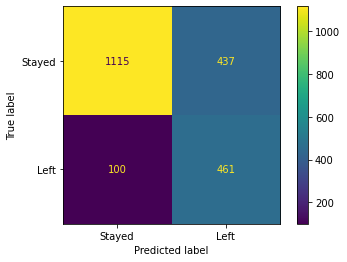

In [34]:
plot_confusion_matrix(clf_xgb,X_test,y_test,values_format='d',display_labels=["Stayed","Left"])

Now we can see that with the updated hyper-parameters, the new model gives ~72% rate of recall for "Left" population which is a significant increase compared to the initial model. However, this increase comes with the cost that the accuracy of predicting "Stayed" population decreases. In a more realistic context, we could argue that accurately predicting clients that tend to leave is more important than predicting those that are more likely to stay. This is the importance of customer retention.

#### 4.4 Visualize the model

In [35]:
clf_xgb=xgb.XGBClassifier(objective='binary:logistic',seed=42,
                          gamma=0,learning_rate=0.05,max_depth=4,
                          reg_lambda=1,subsample=0.9,colsample_bytree=0.5,
                          scale_pos_weight=3,n_estimators=1)
clf_xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=1, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=3, seed=42,
              silent=None, subsample=0.9, verbosity=1)

weight:  {'Contract_Month-to-month': 1, 'Streaming_Movies_Yes': 1, 'Payment_Method_Electronic_check': 2, 'Zip_Code': 1, 'Longitude': 4, 'Paperless_Billing_No': 2, 'Tech_Support_Yes': 3, 'Online_Security_No_internet_service': 1}
gain:  {'Contract_Month-to-month': 1620.81152, 'Streaming_Movies_Yes': 70.5357666, 'Payment_Method_Electronic_check': 50.3479004, 'Zip_Code': 7.01306152, 'Longitude': 10.14406254, 'Paperless_Billing_No': 14.722370605, 'Tech_Support_Yes': 22.74882, 'Online_Security_No_internet_service': 182.386108}
cover:  {'Contract_Month-to-month': 1707.0, 'Streaming_Movies_Yes': 566.5, 'Payment_Method_Electronic_check': 660.375, 'Zip_Code': 256.25, 'Longitude': 84.125, 'Paperless_Billing_No': 141.5, 'Tech_Support_Yes': 405.8333333333333, 'Online_Security_No_internet_service': 1140.5}
total_gain:  {'Contract_Month-to-month': 1620.81152, 'Streaming_Movies_Yes': 70.5357666, 'Payment_Method_Electronic_check': 100.6958008, 'Zip_Code': 7.01306152, 'Longitude': 40.57625016, 'Paperles

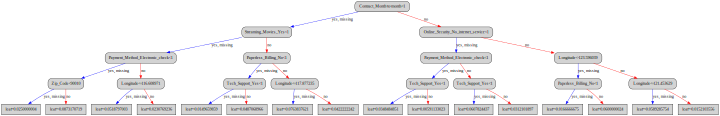

In [36]:
bst=clf_xgb.get_booster()
for importance_type in ('weight','gain','cover','total_gain','total_cover'):
  print('%s: '%importance_type, bst.get_score(importance_type=importance_type))

node_params={'shape':'box',
             'style':'filled, rounded'
             }
leaf_params={'shape':'box',
             'style':'filled'
             }
xgb.to_graphviz(clf_xgb,num_trees=0,size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

From the tree graph and the importance features, we can have some idea of what are the important features and how they were used to make the prediction, which would in turn provide important insights on how the company should collect and use the data in the future.